In [1]:
from os import listdir
import os, random, copy
from PIL import Image
import numpy as np
from collections import defaultdict
import math

In [2]:
#define sigmoid and its derivative for activation & backprop
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def derivSigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

## Question 1 - Import Data

In [3]:
################################################################################
# CSE 253: Programming Assignment 1
# Code snippet by Michael
# Winter 2020
################################################################################
# We've provided you with the dataset in PA1.zip
################################################################################
# To install PIL, refer to the instructions for your system:
# https://pillow.readthedocs.io/en/5.2.x/installation.html
################################################################################
# If you don't have NumPy installed, please use the instructions here:
# https://scipy.org/install.html
################################################################################


''' 
list of face expressions (contempt, neutral are excluded) are:
1. anger
2. disgust
3. fear
4. happiness
5. sadness
6. surprise
'''

def load_data(data_dir="./aligned/"):
	""" Load all PNG images stored in your data directory into a list of NumPy
	arrays.

	Args:
		data_dir: The relative directory path to the CK+ image directory.
	Returns:
		images: A dictionary with keys as emotions and a list containing images associated with each key.
		cnt: A dictionary that stores the # of images in each emotion
	"""
	images = defaultdict(list)

	# Get the list of emotional directory:
	for e in listdir(data_dir):
		# excluding any non-directory files
		if not os.path.isdir(os.path.join(data_dir, e)):
			continue
		# Get the list of image file names
		all_files = listdir(os.path.join(data_dir, e))

		for file in all_files:
			# Load only image files as PIL images and convert to NumPy arrays
			if '.png' in file:
				img = Image.open(os.path.join(data_dir, e, file))
				images[e].append(np.array(img))

	print("Emotions: {} \n".format(list(images.keys())))

	cnt = defaultdict(int)
	for e in images.keys():
		print("{}: {} # of images".format(e, len(images[e])))
		cnt[e] = len(images[e])
	return images, cnt

def balanced_sampler(dataset, cnt, emotions):
	# this ensures everyone has the same balanced subset for model training, don't change this seed value
	random.seed(20)
	print("\nBalanced Set:")
	min_cnt = min([cnt[e] for e in emotions])
	balanced_subset = defaultdict(list)
	for e in emotions:
		balanced_subset[e] = copy.deepcopy(dataset[e])
		random.shuffle(balanced_subset[e])
		balanced_subset[e] = balanced_subset[e][:min_cnt]
		print('{}: {} # of images'.format(e, len(balanced_subset[e])))
	return balanced_subset

def display_face(img):
	""" Display the input image and optionally save as a PNG.

	Args:
		img: The NumPy array or image to display

	Returns: None
	"""
	# Convert img to PIL Image object (if it's an ndarray)
	if type(img) == np.ndarray:
		print("Converting from array to PIL Image")
		img = Image.fromarray(img)

	# Display the image
	img.show()



In [4]:
K = 10 # number of sections after folding
M = 50 # maximum number of epochs


## Training Procedure

In [5]:
# settings

CATEGORIES = ['happiness', 'anger']
EPOCHS = 50
K = 10 # prinsipal components
LOGISTIC = True
LEARNING_RATE = 0.01


In [6]:
# get the data

data_dir = "./aligned/"
dataset, cnt = load_data(data_dir)
# test with happiness and anger
images = balanced_sampler(dataset, cnt, emotions=CATEGORIES)
display_index = 0

Emotions: ['fear', 'surprise', 'sadness', 'happiness', 'anger', 'disgust'] 

fear: 25 # of images
surprise: 83 # of images
sadness: 28 # of images
happiness: 69 # of images
anger: 45 # of images
disgust: 59 # of images

Balanced Set:
happiness: 45 # of images
anger: 45 # of images


In [7]:
#list happiness as a 1, anger as a 0
#emotions_mapping = ["fear", "surprise", "sadness", "happiness", "anger", "disgust"]
X = []
y = []
for i, category in enumerate(CATEGORIES):
    X += images[category]
    y += [i] * len(images[category])
    
#get my feature - label pairs zipped together
all_data = list(zip(X,y))

#randomize the dataset so I can fold properly

random.shuffle(all_data)

def kfold(data, k=10):
    folds = []
    size = int((1/k) * len(data))
    for i in range(0,k):
        folds.append(data[i*size : (i+1)*size])
    return folds


In [8]:
folds = kfold(all_data)
print(len(folds[0]) == len(folds[1]))
print(len(folds))

True
10


## Task 5 - Logistic Regression

In [9]:
class LogisticRegression:
    
    def __init__(self, lr, dim):
        self.lr = lr
        self.w = np.zeros(dim) 
    
    def stochastic_gradient_descent(self, X, labels):
        indices = [i for i in range(len(labels))]
        np.random.shuffle(indices)
        for i in indices:
            
            # make predition
            data = X[i]
            label = labels[i]
            predicted = sigmoid(data.dot(self.w))
            error = label - predicted
            
            # update weights
            for i in range(len(self.w)):
                grad = error * data[i]
                self.w[i] += self.lr * grad
            
    def probabilities(self, X):
        return sigmoid(X.dot(self.w)).reshape(-1)
    

    def logistic_accuracy(self, prob_vec, labels): 
        correct = np.round(prob_vec) == labels
        correct = np.sum(correct)
        accuracy = correct / len(labels)
        return accuracy

    
    def batch_gradient_descent(self, X, labels):
        predicted = self.probabilities(X)
        error = labels - predicted
        grad = X.T.dot(error)
        self.w += self.lr * grad
        

    def loss(self, labels, predicted):
        #cost = np.log(predicted+ 0.0001) * labels + (1 - labels) * np.log(1 - predicted)
        #return - cost.sum() / len(labels)
        #print(cost)
        
        Yis1 = labels == 1
        cost = -(np.log(predicted[Yis1]).sum() + np.log(1 - predicted[~Yis1]).sum())/len(labels)
        return cost

In [10]:
lr = LogisticRegression(0.1, 3)

In [11]:
lr.loss(np.array([1,1]), np.array([1,1]))

-0.0

In [12]:
lr.loss(np.array([1,1]), np.array([0.8,1]))

0.11157177565710485

In [13]:
test_data = np.array([[0.9,0.22,0.44], [0.0,0.22,0.44]])

for i in range(50):
    lr.stochastic_gradient_descent(test_data, np.array([0, 1]))

In [14]:
lr.w

array([-1.52212956,  0.16123376,  0.32246752])

In [15]:
lr.probabilities(test_data)

array([0.23280149, 0.54422342])

In [16]:
lr.loss(np.array([0, 1]), lr.probabilities(test_data))

0.4367025550497474

In [17]:
5 

[0, 0, 0, 0, 1, 0]

[0, 0, 0, 0, 1, 0]

## Softmax

In [18]:
emotions_mapping = ["fear", "surprise", "sadness", "happiness", "anger", "disgust"]


class SoftmaxRegression:
    
    def __init__(self, lr, dim, c):
        self.lr = lr
        self.c = c
        self.w = np.zeros((dim, c)) 
    
    def stochastic_gradient_descent(self, X, labels):
        indices = [i for i in range(len(labels))]
        np.random.shuffle(indices)
        for i in indices:
            
            # make predition
            data = X[i]
            label = labels[i]
            predicted = self.probabilities(data)
            error = label - predicted
            
            # update weights
            for i in range(len(self.w)):
                grad = error * data[i]
                self.w[i] += self.lr * grad
            
    def probabilities(self, X):
        return np.exp(X.dot(self.w)) / np.sum(np.exp(X.dot(self.w)), axis=1).reshape(len(X),1)

    
    def batch_gradient_descent(self, X, labels):
        predicted = self.probabilities(X)
        error = labels - predicted
        grad = X.T.dot(error)
        #grad = np.sum(grad, axis=1).reshape(grad.shape[0], 1)
        self.w += self.lr * grad
        

    def accuracy(self, prob_vec, labels): #prob_vec row is probabilities of a single instance
        numer = 0
        denom = len(labels)
        for i in range(len(labels)):
            y = list(prob_vec[i]).index(max(prob_vec[i]))
            t = list(labels[i]).index(max(labels[i]))
            if y == t:
                numer += 1
        accuracy = numer / denom
        return accuracy
    
    def visualize_weights(self, pca):
        visualized = pca.components.dot(self.w).reshape((-1, self.c))
    
        print(pca.components.shape)
        print(self.w.shape)
        print(visualized[0].shape)
        imgs = [Image.fromarray(img) for img in pca.inverse_transform(visualized)]
        [img.show() for img in imgs]
        return visualized
    
    def loss(self, labels, predicted):
        #return -np.sum(np.sum(labels.T.dot(np.log(predicted)))) # can't have zero values 
        sum_of_score = 0
        for n in range(predicted.shape[0]):
            for cat in range(self.c):
                sum_of_score += labels[n, cat] * np.log(predicted[n, cat])

        return - sum_of_score / predicted.shape[0]


In [19]:
softmax = SoftmaxRegression(0.02, 4, 2)

test_data = np.array([[0.3,0.22,0.44, 0.44], [0.0,0.12,0.2, 0.2], [0.1,0.4,0.4, 0.6]])



#softmax.loss(np.array([[1, 0],[1,0]]), softmax.probabilities(test_data))

In [20]:
softmax.loss(np.array([[1, 0],[1, 0], [1,0]]), np.array([[0.99,0.01], [0.99,0.01], [0.95,0.05]]))

0.023797988698184492

In [21]:
for i in range(50):
    softmax.batch_gradient_descent(test_data, np.array([[1, 0], [1, 0],[0,0]]))

In [22]:
softmax.w

array([[ 0.07005754, -0.17005754],
       [-0.08168231, -0.31831769],
       [ 0.04982869, -0.44982869],
       [-0.06616874, -0.53383126]])

In [23]:
softmax.probabilities(test_data)

array([[0.63406948, 0.36593052],
       [0.55523866, 0.44476134],
       [0.64545635, 0.35454365]])

In [24]:
class PCA:
    def __init__(self, square_data, k=10): # k defaults to 10
        self.square_data = square_data
        M, rows, columns = self.square_data.shape
        self.k = k
        self.num_examples = M
        self.image_vec = np.reshape(square_data, (M, rows*columns))
        self.mean_face = np.mean(self.image_vec, axis=0)
        self.std_face = np.std(self.image_vec, axis=0)
        self.components, self.singular_values = self.get_components()
    
    def get_components(self):
        Phi = (self.image_vec - self.mean_face) / self.std_face 
        A = Phi
        C = np.matmul(A, A.T)
        C = np.divide(C, self.num_examples - 1)
        evals, Vi = np.linalg.eigh(C)
        z = list(zip(evals,Vi))
        z.sort(reverse=True)        
        
        idx = np.argsort(evals)[::-1]
        evecs = Vi[:, idx]
        evecs = evecs[:, :self.k]
        pc = evecs
        
        #final components (num pixels by k matrix)
        components = np.matmul(A.T, pc)
        components = components / np.linalg.norm(components, axis=0)
        #get singluar values
        sorted_evals = np.array([x[0] for x in z])
        postive_evals = sorted_evals[:self.k]
        singular_values = np.sqrt(postive_evals.reshape(1, -1))
        assert np.allclose(np.linalg.norm(components, axis=0), 1)

        return components, singular_values
        
    def transform(self, images):
        return np.array([self.transform_single(i) for i in images])
        
    def transform_single(self, image): #take an image, and pc's, and output compressed image
        image =  image.reshape(1, -1) 
        image = (image - self.mean_face) / self.std_face
        compressed_image_vectors = np.matmul(image, self.components) / self.singular_values
        return compressed_image_vectors.reshape(-1,)
    
    def inverse_transform(self, images):
        return np.array([self.inverse_transform_single(i) for i in images])
    
    def inverse_transform_single(self, image):
        image = (image * self.singular_values).dot(self.components.T) 
        image = image * self.std_face
        image = image + self.mean_face
        image = image.reshape(224, 192)
        return image
    
        #image = np.divide(image * self.singular_values, self.components)
        #image = (self.std_face * image)
        #image = image + self.mean_face
        #image = image.reshape(224, 192)
        #return image
        
    
    '''
    def transform(self, images): #take an image, and pc's, and output compressed image
        M, rows, columns = images.shape
        flat_images = (np.reshape(images, (M, rows*columns)) - self.mean_face) / self.std_face
        print("Shape flat images")
        print(flat_images.shape)
        compressed_image_vectors = np.matmul(flat_images, self.components) / self.singular_values
        return compressed_image_vectors
    '''

In [25]:
    
def split_x_y(data):
    return np.array([item[0] for item in data]), np.array([item[1] for item in data]) 



data = split_x_y(all_data)[0]
pca = PCA(data[0:10], 10)
transformed = pca.transform_single(data[11])
inverse_transformed = pca.inverse_transform_single(transformed)
print(inverse_transformed)
print("vs")
print(data[11])
print(inverse_transformed == data[11])


img = Image.fromarray(inverse_transformed)
img.show()

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
vs
[[ 88  87  88 ... 102 102 103]
 [ 89  87  87 ... 101 101 102]
 [ 88  88  88 ... 102 102 104]
 ...
 [ 67  66  68 ...  76  76  75]
 [ 66  65  66 ...  74  75  75]
 [ 65  63  64 ...  76  76  75]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in sqrt


Fold: 0
Training index: 2
Training index: 3
Training index: 4
Training index: 5
Training index: 6
Training index: 7
Training index: 8
Training index: 9
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[50 50 51 ... 61 60 60]
 [50 49 50 ... 61 62 63]
 [51 51 51 ... 63 64 66]
 ...
 [40 40 40 ... 48 48 49]
 [41 41 40 ... 46 46 45]
 [40 39 38 ... 49 49 48]]
PCA transformed
[ 0.49845016  0.94623586 -0.05710495  0.25494645 -1.41748828  0.11601997
 -0.59675826  0.83598796  0.01925483 -0.31428448]
Training error: 0.5534602149120487, validation error: 0.5687107317200708, accuracy: 0
Training error: 0.45787899093042067, validation error: 0.4820949545890033, accuracy: 0
Training error: 0.3904503703145558, validation error: 0.42010043689395293, accuracy: 0
Training error: 0.3410727894439659, validation error: 0.37420533207628165, accuracy: 0
Training error: 0.30361236891112825, validation error: 0.3391180019727751, accuracy: 0
Training error: 0.27430437616565606, validation error: 0.31152454755837633, 

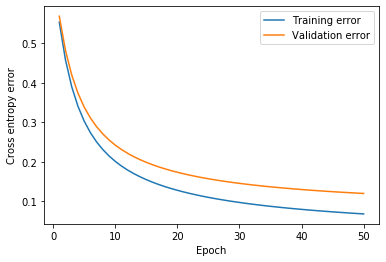

Fold: 1
Training index: 0
Training index: 3
Training index: 4
Training index: 5
Training index: 6
Training index: 7
Training index: 8
Training index: 9
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[44 45 46 ... 51 52 51]
 [43 45 44 ... 50 52 50]
 [44 45 44 ... 51 51 50]
 ...
 [28 29 29 ...  0  0  0]
 [27 27 27 ...  0  0  0]
 [28 28 28 ...  0  0  0]]
PCA transformed
[ 1.06212878  1.03976789  0.04187236 -0.77251337  0.33217023 -0.71647706
  0.21329043 -0.31444142 -0.16340727  0.87774794]
Training error: 0.5546255971615452, validation error: 0.5524232304675053, accuracy: 0
Training error: 0.459878043599027, validation error: 0.4555165560296028, accuracy: 0
Training error: 0.39311822930162427, validation error: 0.3868366443460201, accuracy: 0
Training error: 0.3443207340189096, validation error: 0.3364223304850909, accuracy: 0
Training error: 0.3073795666987582, validation error: 0.29815788479749045, accuracy: 0
Training error: 0.2785409378905908, validation error: 0.2682535873323687, accur

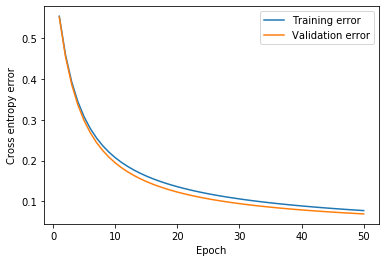

Fold: 2
Training index: 0
Training index: 1
Training index: 4
Training index: 5
Training index: 6
Training index: 7
Training index: 8
Training index: 9
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[44 45 46 ... 51 52 51]
 [43 45 44 ... 50 52 50]
 [44 45 44 ... 51 51 50]
 ...
 [28 29 29 ...  0  0  0]
 [27 27 27 ...  0  0  0]
 [28 28 28 ...  0  0  0]]
PCA transformed
[ 1.04763823  1.13580425 -0.07222746  0.61969961 -0.56295194  0.44909889
 -0.60853401  0.35220825 -0.02425793  0.04372928]
Training error: 0.5505672508870477, validation error: 0.5791347278765164, accuracy: 0
Training error: 0.4530804250874128, validation error: 0.4979221341716031, accuracy: 0
Training error: 0.3844741883612147, validation error: 0.4384199821886836, accuracy: 0
Training error: 0.3344241736596785, validation error: 0.3933417356695047, accuracy: 0
Training error: 0.29662348358635754, validation error: 0.358096431376408, accuracy: 0
Training error: 0.2671881843274356, validation error: 0.3297732303209252, accura

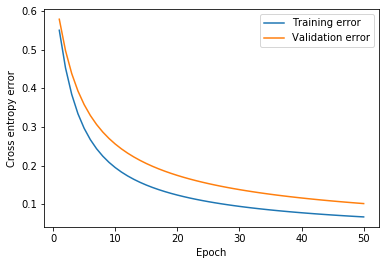

Fold: 3
Training index: 0
Training index: 1
Training index: 2
Training index: 5
Training index: 6
Training index: 7
Training index: 8
Training index: 9
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[44 45 46 ... 51 52 51]
 [43 45 44 ... 50 52 50]
 [44 45 44 ... 51 51 50]
 ...
 [28 29 29 ...  0  0  0]
 [27 27 27 ...  0  0  0]
 [28 28 28 ...  0  0  0]]
PCA transformed
[ 1.13649028  0.80846792 -0.43778367  0.89554031 -0.47315949  0.2920791
 -0.41441289  0.46879756 -0.24127493 -0.18267164]
Training error: 0.5525759818831957, validation error: 0.5889652629061867, accuracy: 0
Training error: 0.45644902413018706, validation error: 0.515429335565513, accuracy: 0
Training error: 0.38876805821395216, validation error: 0.46198337139003903, accuracy: 0
Training error: 0.33935423842463575, validation error: 0.4217637964327335, accuracy: 0
Training error: 0.3019956373773395, validation error: 0.39049388985412237, accuracy: 0
Training error: 0.2728692184770989, validation error: 0.3654870816721984, acc

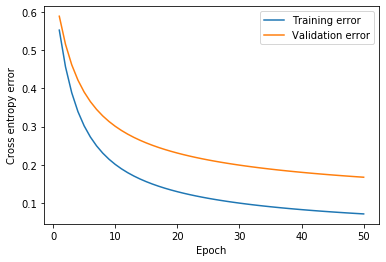

Fold: 4
Training index: 0
Training index: 1
Training index: 2
Training index: 3
Training index: 6
Training index: 7
Training index: 8
Training index: 9
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[44 45 46 ... 51 52 51]
 [43 45 44 ... 50 52 50]
 [44 45 44 ... 51 51 50]
 ...
 [28 29 29 ...  0  0  0]
 [27 27 27 ...  0  0  0]
 [28 28 28 ...  0  0  0]]
PCA transformed
[ 1.13419149 -0.88428527  0.00864528 -0.91132687  0.44436065 -0.1212974
  0.61818799 -0.8846324   0.05980667  0.38984033]
Training error: 0.5528578023766519, validation error: 0.541802549785571, accuracy: 0
Training error: 0.4569219865096351, validation error: 0.4385030017589997, accuracy: 0
Training error: 0.3893711053403001, validation error: 0.3660379235326133, accuracy: 0
Training error: 0.3400463855006338, validation error: 0.3134316371429519, accuracy: 0
Training error: 0.3027501443497235, validation error: 0.27395920546833114, accuracy: 0
Training error: 0.27366931132157457, validation error: 0.24346522855362318, accur

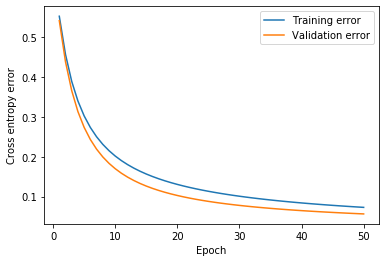

Fold: 5
Training index: 0
Training index: 1
Training index: 2
Training index: 3
Training index: 4
Training index: 7
Training index: 8
Training index: 9
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[44 45 46 ... 51 52 51]
 [43 45 44 ... 50 52 50]
 [44 45 44 ... 51 51 50]
 ...
 [28 29 29 ...  0  0  0]
 [27 27 27 ...  0  0  0]
 [28 28 28 ...  0  0  0]]
PCA transformed
[ 1.0773659   0.99149934  0.20036043 -0.80791436  0.45866214 -0.10396073
  0.51816594 -0.98895531  0.08474232  0.62136079]
Training error: 0.5508388787933858, validation error: 0.531171115217562, accuracy: 0
Training error: 0.4535130901936026, validation error: 0.4234487235517975, accuracy: 0
Training error: 0.3849620930351241, validation error: 0.34957564637727373, accuracy: 0
Training error: 0.3348832200702796, validation error: 0.296882605477659, accuracy: 0
Training error: 0.2969973363850626, validation error: 0.25784430871971903, accuracy: 0
Training error: 0.26744387101958395, validation error: 0.2279451666840036, accur

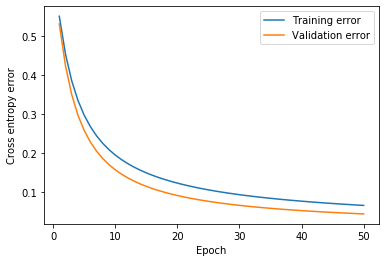

Fold: 6
Training index: 0
Training index: 1
Training index: 2
Training index: 3
Training index: 4
Training index: 5
Training index: 8
Training index: 9
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[44 45 46 ... 51 52 51]
 [43 45 44 ... 50 52 50]
 [44 45 44 ... 51 51 50]
 ...
 [28 29 29 ...  0  0  0]
 [27 27 27 ...  0  0  0]
 [28 28 28 ...  0  0  0]]
PCA transformed
[ 1.16673648  1.08154342 -0.04030733  0.73480593 -0.62044561  0.58670629
 -0.18940719  0.52981285 -0.14927129 -0.95572612]
Training error: 0.5519016822761021, validation error: 0.5371435539262646, accuracy: 0
Training error: 0.45528698675885504, validation error: 0.4317824172401601, accuracy: 0
Training error: 0.3872034221204203, validation error: 0.35854126270075865, accuracy: 0
Training error: 0.33743132387551217, validation error: 0.30573137564555425, accuracy: 0
Training error: 0.29974948123551143, validation error: 0.2662821271406634, accuracy: 0
Training error: 0.270334249822016, validation error: 0.23587848137908848, a

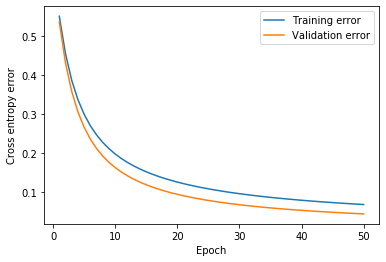

Fold: 7
Training index: 0
Training index: 1
Training index: 2
Training index: 3
Training index: 4
Training index: 5
Training index: 6
Training index: 9
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[44 45 46 ... 51 52 51]
 [43 45 44 ... 50 52 50]
 [44 45 44 ... 51 51 50]
 ...
 [28 29 29 ...  0  0  0]
 [27 27 27 ...  0  0  0]
 [28 28 28 ...  0  0  0]]
PCA transformed
[ 1.10078992  1.12847814 -0.35149785  1.00084347 -0.38913474  0.22121984
 -0.24957997  0.24499864 -0.43708203  0.5567604 ]
Training error: 0.5486913844887478, validation error: 0.5567831467583754, accuracy: 0
Training error: 0.449906131492119, validation error: 0.46126102767491733, accuracy: 0
Training error: 0.3803534663347436, validation error: 0.392502790074252, accuracy: 0
Training error: 0.3295826972052605, validation error: 0.3413503509124069, accuracy: 0
Training error: 0.29121969626815675, validation error: 0.30207929267500006, accuracy: 0
Training error: 0.2613412283308683, validation error: 0.2710854791316492, accur

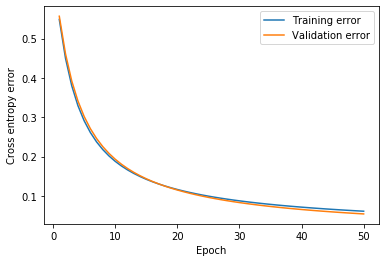

Fold: 8
Training index: 0
Training index: 1
Training index: 2
Training index: 3
Training index: 4
Training index: 5
Training index: 6
Training index: 7
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[44 45 46 ... 51 52 51]
 [43 45 44 ... 50 52 50]
 [44 45 44 ... 51 51 50]
 ...
 [28 29 29 ...  0  0  0]
 [27 27 27 ...  0  0  0]
 [28 28 28 ...  0  0  0]]
PCA transformed
[ 1.03188997  1.08253718  0.01958288 -0.84822214  0.39795964 -0.23781604
  0.15137433 -0.49006757 -0.07995404  0.71369792]
Training error: 0.5467505850677262, validation error: 0.591956613659526, accuracy: 0
Training error: 0.44664871997259603, validation error: 0.5199011652819091, accuracy: 0
Training error: 0.37619495710314155, validation error: 0.4671936293817793, accuracy: 0
Training error: 0.3247991828774039, validation error: 0.42737788993770987, accuracy: 0
Training error: 0.28599639377960956, validation error: 0.39636099135750325, accuracy: 0
Training error: 0.25580458114472193, validation error: 0.3715338335324986, a

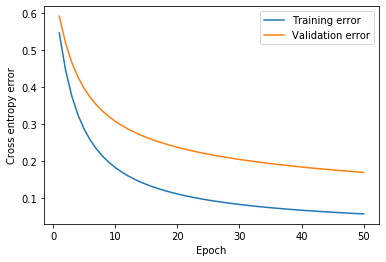

Fold: 9
Training index: 1
Training index: 2
Training index: 3
Training index: 4
Training index: 5
Training index: 6
Training index: 7
Training index: 8
(9, 224, 192)
(9, 224, 192)
(72, 224, 192)
[[138 104  90 ... 143 151 150]
 [144 108  90 ... 143 148 143]
 [172 147 118 ... 141 144 140]
 ...
 [116 121 122 ... 134 133 131]
 [118 121 122 ... 134 133 130]
 [117 119 120 ... 132 132 130]]
PCA transformed
[ 1.80570617  1.3335599   0.88805718 -1.02493134  0.75653649 -0.50841783
  0.55316109 -0.57721461  1.65244786 -0.36606303]
Training error: 0.5486576183458348, validation error: 0.5788760320638224, accuracy: 0
Training error: 0.4498638352681213, validation error: 0.49857699619201523, accuracy: 0
Training error: 0.38033883942045604, validation error: 0.44051042325244705, accuracy: 0
Training error: 0.3296268792249446, validation error: 0.39705079561422874, accuracy: 0
Training error: 0.29134158379398184, validation error: 0.36344400151863143, accuracy: 0
Training error: 0.26154848265759517, v

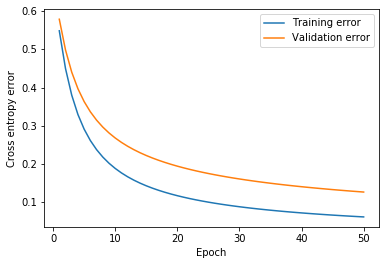

In [29]:
import matplotlib.pyplot as plt
#from pca import PCA

class EpochData:
    def __init__(self):
        self.acc = []
        self.error = []
    
    def save(self, error, acc):
        self.error.append(error)
        self.acc.append(acc)
        
    def add(self, epoch_data):
        if self.acc is None:
            self.acc = epoch_data.acc
            self.error = epoch_data.acc
        else:
            self.acc += epoch_data.acc
            self.error += epoch_data.acc
            
    
    def score(self):
        return self.error[-1]
        
        
def transform(pca, data):
    labels = data[1]
    if not LOGISTIC: # if softmax
        labels = one_hot_encode(labels)
    return pca.transform(data[0]), labels
    #np.array([pca.transform(i)[0] for i in data[0]]), labels

def visualize_data(plots, legends, x_label, y_label):
    x = np.arange(1, len(plots[0]) + 1)
    for data in plots:
        plt.plot(x, data)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.legend(legends)
    plt.show()
    
def split_x_y(data):
    return np.array([item[0] for item in data]), np.array([item[1] for item in data]) 

def one_hot_encode(labels):
    new_labels = np.zeros((len(labels), len(CATEGORIES)))
    new_labels[np.arange(labels.size), labels] = 1
    return new_labels

def train():
    best_model = None
    
    folds = kfold(all_data)
    avg_epoch_data = EpochData()
    
    
    k = len(folds)
    for fold in range(k):
        # define the model
        if LOGISTIC:
            model = LogisticRegression(LEARNING_RATE, K)
        else:
            model = SoftmaxRegression(LEARNING_RATE, K, len(CATEGORIES))

        # split data
        val_data, test_data = split_x_y(folds[fold]), split_x_y(folds[(fold + 1) % k])
        train_data = None
        print("Fold: " + str(fold))
        for i in range(k):
            if i != fold and i != ((fold + 1) % k):
                print("Training index: " + str(i))
                if train_data is None:
                    train_data = folds[i]
                else:
                    train_data = np.concatenate((train_data, folds[i]))
        train_data = split_x_y(train_data)
        print(val_data[0].shape)
        print(test_data[0].shape)
        print(train_data[0].shape)

        print(train_data[0][0])
        pca = PCA(train_data[0], K) # PCA(10) #
        #pca.fit(train_data[0])
        # PCA and one_hot
        train_data, test_data, val_data = transform(pca, train_data), transform(pca, test_data), transform(pca, val_data)        
        print("PCA transformed")
        print(train_data[0][0])
        validation_performance = EpochData()
        training_performance = EpochData() 
        
        
        for epoch in range(EPOCHS):
            model.batch_gradient_descent(train_data[0], train_data[1])
            #print(model.probabilities(train_data[0]))
            train_prob = model.probabilities(train_data[0])
            val_prob = model.probabilities(val_data[0])
            
            training_error = model.loss(train_data[1], train_prob)
            validation_error = model.loss(val_data[1], val_prob)
            
            traning_acc = 0 #model.accuracy(train_prob, train_data[1])
            validation_acc = 0 # model.accuracy(val_prob, val_data[1])
            
            print("Training error: {}, validation error: {}, accuracy: {}".format(training_error, validation_error, traning_acc))
        
            # save
            validation_performance.save(validation_error, validation_acc)
            training_performance.save(training_error, traning_acc)
        
        
        # plot the graphs
        data_to_plot = [training_performance.error, validation_performance.error]
        legends = ["Training error", "Validation error"]
        visualize_data(data_to_plot,legends, "Epoch", "Cross entropy error")
                
        # save the validation data to the model
        model.epoch_data = validation_performance 
        
        # save the best model
        if best_model is None:
            best_model = model
        elif best_model.epoch_data.score() > model.epoch_data.score():
            best_model = model
        
        #best_model.visualize_weights(pca)
            

train()


In [ ]:
test_data = np.array([
    [[40, 33, 34], 
     [54, 34, 22]],
    
    [[34, 40, 34], 
     [23, 32, 32]],

    [[60, 30, 64], 
     [73, 62, 72]]])

test_img = np.array([[34, 36, 45], [34, 36, 45]])

In [ ]:
pca = PCA2(np.array(test_data), 1)

In [ ]:
pca.transform_single(test_img)

In [ ]:
print(pca.components)

In [ ]:
print(pca.singular_values)

In [ ]:
from pca import PCA

pca1 = PCA(1)

In [ ]:
pca1.fit(test_data)

In [ ]:
pca1.transform(test_img)

In [ ]:
print(pca1.p_components)

In [ ]:
print(pca1.s_vals)

In [ ]:
def logistic_accuracy(prob_vec, labels): 
    correct = np.round(prob_vec) == labels
    correct = np.sum(correct)
    accuracy = correct / len(labels)
    return accuracy

def softmax_accuracy(prob_vec, labels): #prob_vec row is probabilities of a single instance
    numer = 0
    denom = len(labels)
    for i in range(len(labels)):
        y = prob_vec[i].index(max(prob_vec[i]))
        t = labels[i].index(max(labels[i]))
        if y == t:
            numer += 1
    accuracy = numer / denom
    return accuracy


print(logistic_accuracy(logistic_prob_vec, logistic_labels))
print(softmax_accuracy(softmax_prob_vec, softmax_labels))